# Financial Time Series Analysis: Programming Tutorial [PART III]

Course material for CMU 46-929, Spring 2023 (Instructor: Arun Kumar Kuchibhotla).

Written & presented by YJ Choe ([yjchoe@cmu.edu](mailto:yjchoe@cmu.edu)).

---

This is part III of the tutorial series on financial time series prediction.

In this notebook, we focus on fitting the ARMA family of models using `statsmodels`.


### Part I: Diagnostics, Trend Fitting, and Seasonal Decomposition

See notebook [`Tutorial-01-SeasonalDecomposition.ipynb`](Tutorial-01-SeasonalDecomposition.ipynb).

### Part II: Model-Free Nonparametric Prediction Methods

See notebook [`Tutorial-02-ModelFreePrediction.ipynb`](Tutorial-02-ModelFreePrediction.ipynb).

### Part III: The ARMA Family of Models: $\mathrm{MA}(q)$, $\mathrm{AR}(p)$, and $\mathrm{ARMA}(p, q)$
- [Samples from ARMA Models](#Samples-from-ARMA-Models)
- [Diagnostics and Tests for AR Models (Dickey-Fuller)](#Diagnostics-and-Tests-for-AR-Models)
- [Fitting ARMA Models](#Fitting-ARMA-Models)
- [Forecasting with ARMA Models](#Forecasting-with-ARMA-Models)

---

## Setup

In [156]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tools.eval_measures import mse

import warnings
warnings.filterwarnings("ignore")  # not advised for general purposes

In [157]:
"""
Utility functions
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# 2023 fix
import pandas_datareader.data as pdr
import yfinance as yf


# yf.pdr_override() # causes error 2025


FIGSIZE = (12, 4)
PLOT_STYLE = "seaborn-v0_8-colorblind"


def tsplot(
        y,
        title="",
        lags=None,
        figsize=(FIGSIZE[0], 2 * FIGSIZE[1]),
        style=PLOT_STYLE,
):
    """Plot a time series with a QQ-plot and an autocorrelation plot."""
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (1, 0))
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("Normal QQ-plot")
        fig.tight_layout()


def compute_returns(
        y,
        symbol,
        period=1,
        use_relative=False,
        use_log=True,
        plot=False,
        **plot_kwargs,
) -> pd.Series:
    """Compute the (relative) (log-)returns of a time series."""
    assert not (use_relative and use_log), \
        "can only compute either relative or log returns"
    if use_relative:
        returns = (y.diff(period) / y.shift(period)).dropna()
        name = "RelativeReturns"
    else:
        returns = (y / y.shift(period)).dropna()
        name = "Returns"
        if use_log:
            returns = np.log(returns)
            name = "LogReturns"

    returns = returns[::period]
    returns.rename(name, inplace=True)

    if plot:
        days_str = f"{period}-day" if period > 1 else "Daily"
        tsplot(
            returns,
            title=f"{days_str} {name}: {symbol}",
            **plot_kwargs,
        )
    return returns


def get_returns_yahoo(
        symbol,
        start,
        end,
        n_days=1,
        use_log=True,
        plot=False,
        **plot_kwargs,
) -> pd.Series:
    """Retrieve and (optionally) plot
    the `n_days`-day (log-)returns of a stock."""
    price = pdr.get_data_yahoo(symbol, start, end)
    adjclose = price["Adj Close"]
    returns = (adjclose / adjclose.shift(n_days)).dropna()
    if use_log:
        returns = np.log(returns)

    returns = returns[::n_days]
    name = "LogReturns" if use_log else "Returns"
    if n_days > 1:
        name += f"{n_days}Day"
    returns.rename(name, inplace=True)

    if plot:
        days_str = f"{n_days}-day" if n_days > 1 else "Daily"
        log_str = "log-" if use_log else ""
        tsplot(
            returns,
            title=f"{days_str} {log_str}returns: {symbol}",
            **plot_kwargs,
        )
    return returns


def read_ts_data(csv_filename, time_column,
                 start=None, end=None, sort_index=True):
    """Read a time series dataset in a csv file
    (e.g., from the Wall Street Journal page)."""
    df = pd.read_csv(csv_filename).set_index(time_column)
    # set index to a datetime
    df.index = pd.to_datetime(df.index)
    # strip columns of whitespaces
    df.columns = [col.strip() for col in df.columns]
    if start is not None:
        df = df[df.index >= start]
    if end is not None:
        df = df[df.index <= end]
    return df.sort_index() if sort_index else df


def get_airline_passengers(
        start,
        end,
        use_log=False,
        plot=False,
        url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
        **plot_kwargs,
) -> pd.Series:
    """Retrieve and (optionally) plot the monthly airline passengers dataset."""
    passengers = pd.read_csv(url).set_index("Month")
    # get DatetimeIndex(freq="MS")
    passengers.index = pd.to_datetime(passengers.index).to_period().to_timestamp()
    passengers = passengers.loc[start:end, "Passengers"]
    if use_log:
        passengers = np.log(passengers)
    if plot:
        log_str = "Log of " if use_log else ""
        tsplot(
            passengers,
            log_str + "Number of monthly airline passengers (thousands)",
            **plot_kwargs,
        )
    return passengers

In [158]:
"""
time series forecasters
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from scipy.linalg import toeplitz
from numpy.lib.stride_tricks import sliding_window_view

from statsmodels.nonparametric.kernel_regression import KernelReg

from typing import Tuple
from tqdm import trange


class ModelFreeLinearPredictor:
    """Best linear predictor for model-free time series forecasting.

    Note:
        This implementation relies on computing
        the inverse of a (sqrt(T), sqrt(T))-shaped toeplitz matrix.
        For large T, see, e.g., the Durbin-Levinson algorithm.

    Args:
        xs: input time series for model fitting
        window_size: size of the lookback window
            (how many past time points to use as covariates)
            Default: sqrt(len(xs)).

    Attributes (most computed lazily in `self.fit()`):
        t: length of xs
        window_size: number of past values used for prediction
        acorr: autocorrelation on xs
        mu: mean of xs
        Gamma: the (sqrt(T), sqrt(T)) autocorrelation matrix of predictors
        Gamma_inv: the inverse of Gamma.
    """
    def __init__(
            self,
            xs: pd.Series,
            window_size: int = None,
    ):
        self.xs = xs if isinstance(xs, pd.Series) else pd.Series(xs)

        assert self.xs.index.is_monotonic_increasing
        self.t = len(xs)
        if window_size is None:
            self.window_size = int(np.ceil(np.sqrt(self.t))) + 1  # 0, 1, ..., [sqrt(T)]
        else:
            assert window_size < self.t
            self.window_size = window_size

        # lazy evaluation
        self.acorr = None
        self.mu = None
        self.Gamma = None
        self.Gamma_inv = None

    def fit(self):
        """Fit the linear model by precomputing the mean and the autocorrelation,
        constructing the Gamma matrix, and computing its inverse.

        Returns `self`.
        """
        self.mu = np.mean(self.xs)
        self.acorr = tsa.acf(self.xs, nlags=self.t + 1)  # store all acorr's
        # below is a custom implementation of the acf function (same results):
        # def compute_acorr(xs, nlags=30):
        #     """Compute the mean and the autocorrelation functions."""
        #     mu = np.mean(xs)
        #     acov = np.zeros(nlags + 1)
        #     acov[0] = np.var(xs)
        #     for h in range(1, nlags + 1):
        #         acov[h] = ((xs - mu) * (xs.shift(h) - mu)).dropna().mean()
        #     acorr = acov / acov[0]
        #     return mu, acorr

        # one-liner for constructing Gamma
        self.Gamma = toeplitz(self.acorr[:self.window_size])
        # constructing it manually is also fine (less efficient, though): e.g.,
        # self.Gamma = np.array([
        #     np.concatenate([self.acorr[1:t + 1][::-1],
        #                     self.acorr[:self.window_size - t]])
        #     for t in range(self.window_size)
        # ])
        self.Gamma_inv = np.linalg.inv(self.Gamma)  # may be slow for large T!
        return self

    def predict_in_sample(self, k: int = 1) -> pd.Series:
        """Make predictions *in-sample*,
        i.e., X_{[sqrt(T)]+1}, X_{[sqrt(T)]+2}, ..., X_T.

        Note that the value of k is fixed in this case.
        """
        # larger lags first (reversed)
        eta = self.acorr[k : self.window_size + k][::-1]
        beta = self.Gamma_inv.dot(eta)
        alpha = self.mu * (1 - beta.sum())

        X = sliding_window_view(self.xs, self.window_size)[:-k, :]
        predictions_in_sample = alpha + X.dot(beta)
        t_index = self.xs.index[self.window_size + k - 1:]
        assert len(predictions_in_sample) == len(t_index)
        return pd.Series(predictions_in_sample, index=t_index)

    def forecast(
            self,
            start: int = 1,
            end: int = 31,
            t_index: pd.Index = None,
    ) -> pd.Series:
        """Predict X_{T+k} for k = start, ..., end - 1.

        If `index` is provided, it is interpreted as the range for k.
        In this case, `start` and `end` are ignored.

        Maximum forecast horizon is the number of training data points (`t`).

        *Warning:* k starts from 1 and not zero.
        """

        # Use either index or (start, end) and adjust the other
        if t_index is not None:
            start, end = 1, len(t_index) + 1
        else:
            t_index = np.arange(start, end)

        # Vectorized prediction for k = start, ..., end - 1.
        # each column of etas is eta[k]. (vector; larger lags first)
        etas = np.vstack([
            self.acorr[k : k + self.window_size][::-1]
            for k in range(start, end)
        ]).T
        betas = self.Gamma_inv.dot(etas)
        alpha = self.mu * (1 - betas.sum(axis=0))
        X = self.xs[-self.window_size:].to_numpy()
        predictions = alpha + X.dot(betas)

        return pd.Series(data=predictions, index=t_index)


class ModelFreeNonparametricPredictor:
    """Model-free nonparametric prediction of a time series
    using a fixed window.

    The nonparametric predictor is a local linear regression (LLR).
    (`statsmodels.nonparametric.kernel_regression.KernelReg`)

    Optionally computes a prediction interval for forecasts,
    using a second nonparametric volatility forecaster.

    Each lag (k) is treated separately.
    """

    def __init__(
            self,
            xs: pd.Series,
            window_size: int = None,
            max_k: int = 12,
            kernel: str = "gaussian",
            bandwidth: float = None,
            compute_interval: bool = True,
    ):
        self.xs = xs
        assert self.xs.index.is_monotonic_increasing
        self.t = len(xs)
        if window_size is None:
            self.window_size = int(np.ceil(np.sqrt(self.t))) + 1  # 0, 1, ..., [sqrt(T)]
            if self.window_size > 20:
                print(f"warning: nonparametric regression may be too slow"
                      f"for larger window sizes (got: {self.window_size})")
        else:
            assert window_size < self.t
            self.window_size = window_size
        # sliding window of the time series (the design matrix)
        self.windows = sliding_window_view(self.xs, self.window_size)

        self.max_k = max_k
        self.kernel = kernel
        self.bandwidth = bandwidth
        if isinstance(self.bandwidth, float):
            self.bandwidth = [self.bandwidth for _ in range(self.window_size)]
        self.compute_interval = compute_interval

        # lazily initialize one forecaster per lag
        self.mean_forecasters = {k: None for k in range(1, max_k + 1)}
        self.vol_forecasters = {k: None for k in range(1, max_k + 1)}

        # last w data points are the input to the predictions
        self.predictors = self.windows[-1]
        # each column is each k value
        self.predictions_in_sample = pd.DataFrame(
            columns=pd.RangeIndex(1, max_k + 1, name="k"))
        # quantiles are populated in fit() and used for prediction intervals
        self.quantiles_in_sample = {k: [] for k in range(1, max_k + 1)}

    def fit(self, verbose: bool = False):
        """'Fit' a nonparametric regression model with the specified window size.

        If `self.compute_interval == True`, the method also fits
        a volatility forecaster and uses it to compute
        the empirical quantiles of standardized residuals
        (used for prediction intervals).

        Returns `self`.
        """
        if verbose:
            k_range = trange(1, self.max_k + 1, desc="local linear regression")
        else:
            k_range = range(1, self.max_k + 1)
        for k in k_range:
            X_k = self.windows[:-k, :]
            y_k = self.xs[self.window_size + k - 1:].to_numpy()
            assert len(X_k) == len(y_k)

            # mean prediction via local linear regression
            mean_fct = KernelReg(
                y_k,
                X_k,
                var_type="c" * self.window_size,
                reg_type="ll",
                ckertype=self.kernel,
                bw=self.bandwidth if self.bandwidth is not None else "cv_ls",
            )
            self.mean_forecasters[k] = mean_fct

            # volatility prediction via local linear regression (separately)
            # TODO: allow separate bandwidths for mean and volatility predictors
            if self.compute_interval:
                mean_preds = self.predict_in_sample(k=k)
                residuals = y_k - mean_preds
                # fit volatility (absolute residuals)
                vol_fct = KernelReg(
                    np.abs(residuals),
                    X_k,
                    var_type="c" * self.window_size,
                    reg_type="ll",
                    ckertype=self.kernel,
                    bw=self.bandwidth if self.bandwidth is not None else "cv_ls",
                )
                self.vol_forecasters[k] = vol_fct

                # precompute empirical quantiles of standardized residuals
                vol_preds, _ = vol_fct.fit(X_k)
                self.quantiles_in_sample[k] = \
                    (residuals / vol_preds).sort_values().to_numpy()

        # predictors for future forecasts
        self.predictors = self.windows[-1, :]
        return self

    def predict_in_sample(self, k: int = 1) -> pd.Series:
        """Make mean predictions *in-sample*,
        i.e., X_{[sqrt(T)]+1}, X_{[sqrt(T)]+2}, ..., X_T.

        Note that the value of k is fixed in this case.
        """
        assert 1 <= k <= self.max_k
        # avoid re-computing if already available
        if not self.predictions_in_sample[k].dropna().empty:
            return self.predictions_in_sample[k]

        X_k = self.windows[:-k, :]
        # prediction on the entire input sample X
        predictions_in_sample, _ = self.mean_forecasters[k].fit(X_k)
        t_index = self.xs.index[self.window_size + k - 1:]
        predictions_in_sample = pd.Series(predictions_in_sample,
                                          index=t_index)

        # store predictions to avoid re-computation
        self.predictions_in_sample[k] = predictions_in_sample
        return predictions_in_sample

    def forecast(
            self,
            start: int = 1,
            end: int = 12,
            t_index: pd.Index = None,
            predictors: np.ndarray = None,
            alpha: float = 0.05,
    ) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """Predict X_{T+k} given predictors (X_T, X_{T-1}, ..., X_{T-window_size}),
        for k = start, ..., end - 1.

        If `X_pred` is `None`, then
        prediction is made using the last `window_size` points from the training data.

        `start` and `end` denote the forecasting horizon,
        following the last date of the predictors `X_pred`.

        If `t_index` is provided, it is interpreted as the date range for k.
        In this case, `start` and `end` are ignored.

        *Warning:* k starts from 1 and not zero.
        """
        assert 1 <= start <= end - 1 <= self.max_k

        # Use either index or (start, end) and adjust the other
        if t_index is not None:
            start, end = 1, len(t_index) + 1
        else:
            t_index = np.arange(start, end)

        # make k-step-ahead forecasts
        predictors = self.predictors if predictors is None else predictors
        mean_predictions = [
            self.mean_forecasters[k].fit(predictors)[0].item()
            for k in range(start, end)
        ]
        mean_predictions = pd.Series(mean_predictions, index=t_index)

        if self.compute_interval:
            # compute sigma-hat
            vol_predictions = [
                self.vol_forecasters[k].fit(predictors)[0].item()
                for k in range(start, end)
            ]
            vol_predictions = pd.Series(vol_predictions, index=t_index)

            # compute in-sample standardized residuals for quantiles
            z_lo, z_hi = [], []
            for k in range(start, end):
                quantiles_k = self.quantiles_in_sample[k]
                n_quantiles = len(quantiles_k)
                q_lo = int(np.floor(n_quantiles * alpha / 2))
                q_hi = int(np.ceil(n_quantiles * (1 - alpha / 2)))
                z_lo.append(quantiles_k[q_lo])
                z_hi.append(quantiles_k[q_hi])

            pi_lower = mean_predictions + z_lo * vol_predictions
            pi_upper = mean_predictions + z_hi * vol_predictions

            if (pi_lower > pi_upper).any():
                print("WARNING: volatility predictions may be null")

        else:
            pi_lower, pi_upper = None, None

        return mean_predictions, pi_lower, pi_upper

In [159]:
# set styles globally for matplotlib and seaborn
FIGSIZE = (12, 4)
PLOT_STYLE = "seaborn-v0_8-colorblind"

plt.style.use(PLOT_STYLE)
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
)

### Data

We now return to the two datasets we've used in Part I:
the prices and the log-returns of a stock, and the monthly number of airline passengers.

(Why would log-returns be useful for ARMA modeling?)

In [160]:
# training data
TRAIN_START_DATE = "2019-03-14" # "2021-12-01"
TRAIN_END_DATE = "2022-11-30"

# test set (validation set from part II)
TEST_START_DATE = "2022-12-01"
TEST_END_DATE = "2022-12-14"

In [161]:
SYMBOL = "AAPL"
PERIOD = 1
MAX_HORIZON = 12  # maximum forecasting horizon

training data size: 938


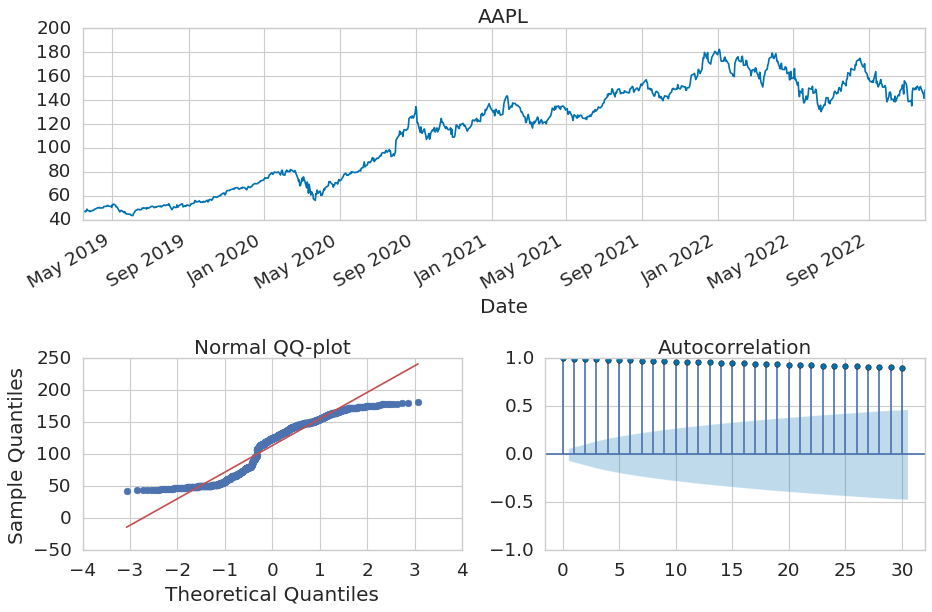

In [162]:
prices = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=TRAIN_START_DATE,
    end=TRAIN_END_DATE,
)["Close"]
prices.name = SYMBOL

print("training data size:", len(prices))
tsplot(prices, SYMBOL)

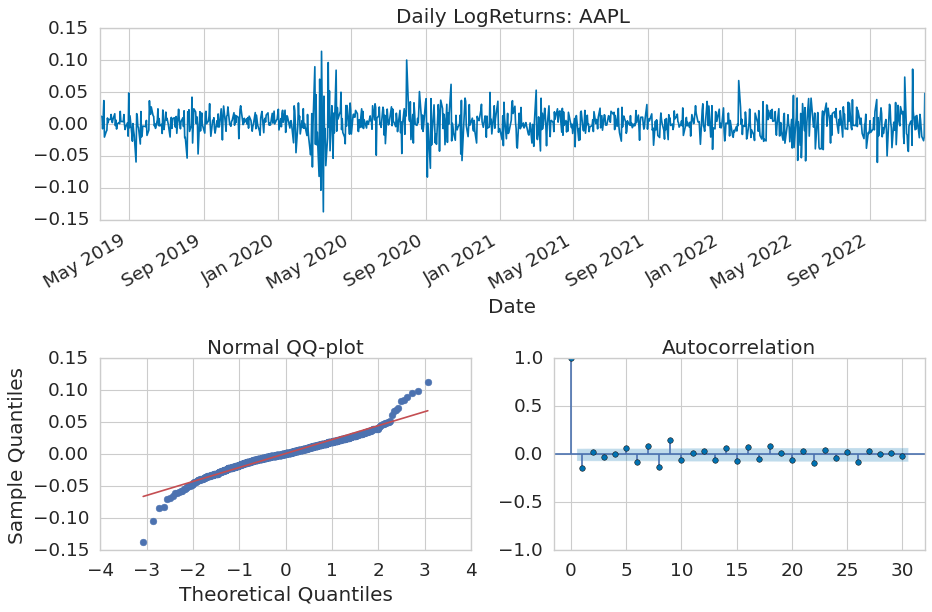

In [163]:
log_returns = compute_returns(
    prices,
    SYMBOL,
    period=1,
    use_relative=False,
    use_log=True,
    plot=True,
)

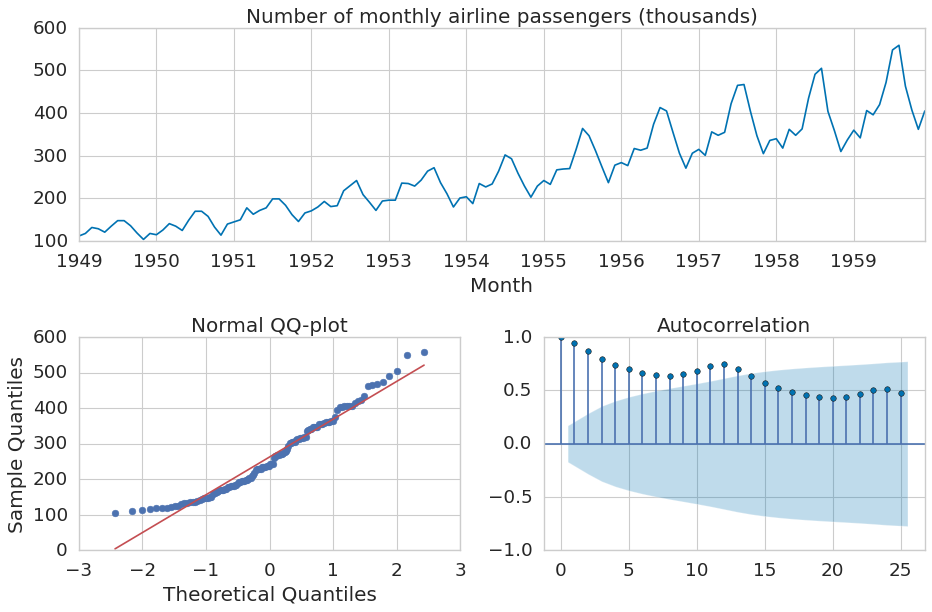

In [164]:
# training data for passengers
PASSENGERS_START = "1949-01-01"
PASSENGERS_END = "1959-12-01"

passengers = get_airline_passengers(PASSENGERS_START, PASSENGERS_END,
                                    use_log=False, plot=True, lags=25)
log_passengers = pd.Series(np.log(passengers), name="LogPassengers")

We also load up the test set for forecast evaluation later.

In [165]:
# retrieve one earlier day to compute the log-returns
prices_test = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=pd.to_datetime(TEST_START_DATE) - timedelta(days=1),
    end=TEST_END_DATE,
)["Close"]

# 12/15/2022 to 12/31/2022
log_returns_test = compute_returns(
    prices_test,
    symbol=SYMBOL,
    period=PERIOD,
    use_log=True,
)
prices_test = prices_test.iloc[1:]

In [166]:
passengers_test = get_airline_passengers("1960-01-01", "1961-12-01", use_log=False, plot=False)
log_passengers_test = get_airline_passengers("1960-01-01", "1961-12-01", use_log=True, plot=False)

---

## The ARMA Family of Models: $\mathrm{MA}(q)$, $\mathrm{AR}(p)$, and $\mathrm{ARMA}(p, q)$

The ARMA "family" of models --- $\mathrm{MA}(q)$, $\mathrm{AR}(p)$, and $\mathrm{ARMA}(p, q)$ --- are a class of linear models that approximate weakly stationary time series following the Wold decomposition.

The theory will covered in the future classes; here, we will jump right into the final forms and the practical applications of the models.
In the following, $(X_t)_{t\geq 0}$ denotes the noise process of a time series, and $(\epsilon_t)_{t \geq 0}$ denotes a white noise (WN) process with mean zero and variance $\sigma^2$.

### Moving-average (MA) model of order $q$

The $\mathrm{MA}(q)$ model asserts that the stationary process is a linear combination of the $q$ previous variables (and the current one) in the white noise process.
$$X_t = \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t.$$
If $(X_t)_{t\geq 0}$ follows an $\mathrm{MA}(q)$ model, then the coefficients $\theta_1, \dotsc, \theta_q$ are the _autocorrelations_ (`acf`) of the process.
The $\mathrm{MA}(q)$ is always stationary, but not always invertible.

### Autoregressive (AR) model of order $p$

The $\mathrm{AR}(p)$ model asserts that the time series is a linear combination of the $p$ previous variables in the time series itself (with a white noise variable).
$$X_t = \sum_{i=1}^p \phi_i X_{t-i} + \epsilon_t.$$
If $(X_t)_{t\geq 0}$ follows an $\mathrm{AR}(p)$ model, then the coefficients $\phi_1, \dotsc, \phi_p$ are the _partial autocorrelations_ (`pacf`) of the process.
The $\mathrm{AR}(p)$ is always invertible, but _not always stationary_.

### Autoregressive moving-average (ARMA) model of order $(p, q)$

The $\mathrm{ARMA}(p, q)$ model assumes that the time series is a linear combination of both $\mathrm{AR}(p)$ and $\mathrm{MA}(q)$ components.
$$X_t = \sum_{i=1}^p\phi_i X_{t-i} + \sum_{j=1}^q\theta_j \epsilon_{t-j} + \epsilon_t.$$

## Samples from ARMA Models

We start by generating some samples from each of the ARMA models.

`statsmodels` has a built-in method [`tsa.ArmaProcess.from_coefs(ar_coefs, ma_coefs)`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_process.ArmaProcess.html) for this purpose.

Recall that an $\mathrm{AR}(p)$ model is _stationary_ if and only if the roots of the autoregressive polynomial,
$$\phi(z) = 1 - \phi_1z - \dotsb - \phi_pz^p,$$
are all less than 1 in absolute value.

Also, an $\mathrm{MA}(q)$ model is _invertible_ if and only if the roots of the moving-average polynomial
$$\theta(z) = 1 + \theta_1z + \dotsb + \theta_qz^q,$$
are all less than 1 in absolute value. (An $\mathrm{MA}(q)$ model is always stationary.)

In [167]:
np.random.seed(20230327)

In [168]:
def plot_arma_comparisons(ar_coefs, ma_coefs, T=500):
    """Plot MA, AR, and ARMA samples given the coefficients."""
    ma_process = tsa.ArmaProcess.from_coeffs(arcoefs=None, macoefs=ma_coefs)
    ar_process = tsa.ArmaProcess.from_coeffs(arcoefs=ar_coefs, macoefs=None)
    arma_process = tsa.ArmaProcess.from_coeffs(arcoefs=ar_coefs, macoefs=ma_coefs)
    p = len(ar_coefs)
    q = len(ma_coefs)

    # some quick diagnostics
    processes = {
        f"MA({q})": ma_process,
        f"AR({p})": ar_process,
        f"ARMA({p}, {q})": arma_process,
    }
    for name, process in processes.items():
        print(f"{name} stationarity & invertibility:",
              process.isstationary, process.isinvertible)

    samples = pd.DataFrame({
        r"$t$": np.arange(T),
        f"MA({q})": ma_process.generate_sample(T),
        f"AR({p})": ar_process.generate_sample(T),
        f"ARMA({p}, {q})": arma_process.generate_sample(T),
    }).melt(id_vars=[r"$t$"], var_name="Model", value_name=r"$X_t$")

    height = FIGSIZE[1] / 2
    fg = sns.relplot(
        x=r"$t$",
        y=r"$X_t$",
        hue="Model",
        row="Model",
        kind="line",
        linewidth=2,
        alpha=0.9,
        aspect=FIGSIZE[0] / height,
        height=height,
        data=samples,
    )
    return samples

### Comparing Samples from MA(2), AR(2), and ARMA(2)

MA(2) stationarity & invertibility: True True
AR(2) stationarity & invertibility: True True
ARMA(2, 2) stationarity & invertibility: True True


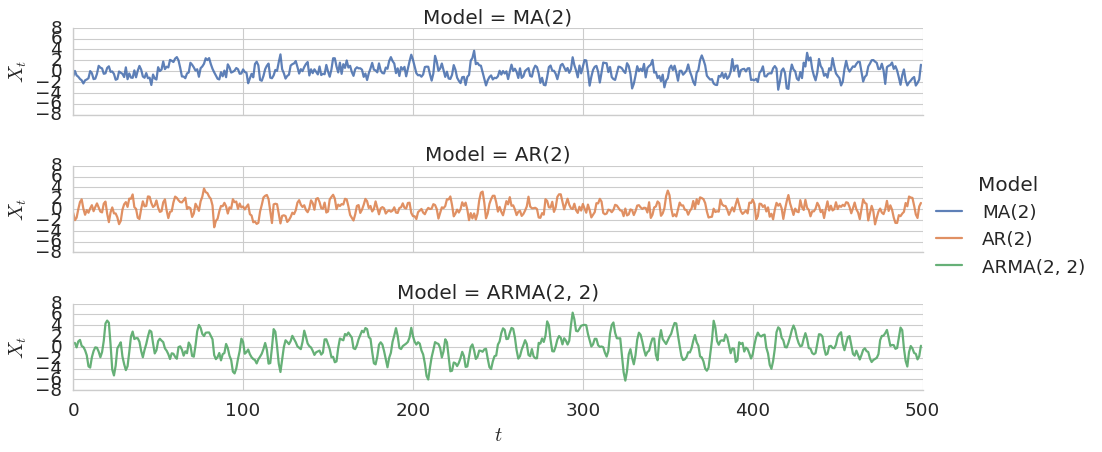

In [169]:
# more "white noise"-like
ar_coefs = np.array([0.75, -0.25])
ma_coefs = np.array([0.65, 0.35])

samples = plot_arma_comparisons(ar_coefs, ma_coefs)

How do we distinguish between these seemingly similar time series?

We can check that the autocorrelations and the partial autocorrelations roughly correspond to the coefficients of the MA(2) and the AR(2) processes, respectively. Note that the AR model will also show a significant ACF (not just PACF), because it also has an MA representation (more on this in class).

Also note that these are estimates of the data, so they may not be the most accurate.

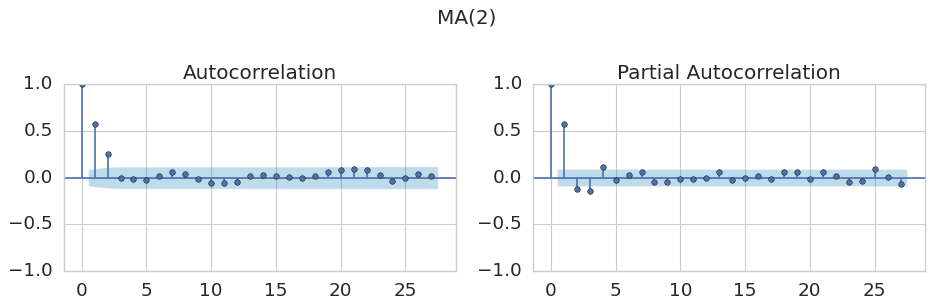

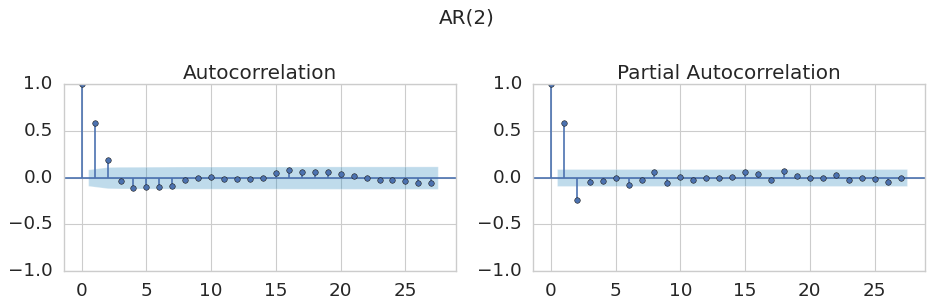

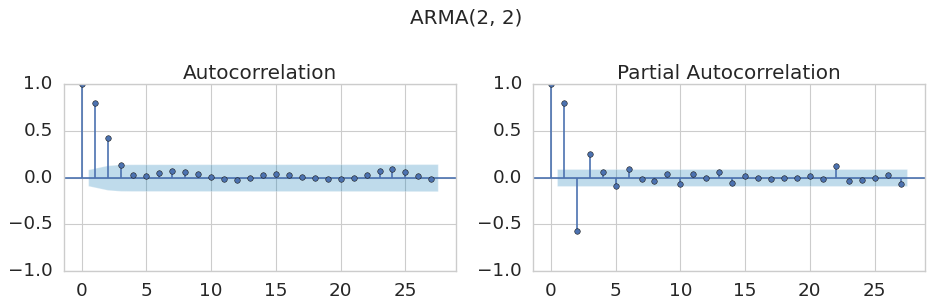

In [170]:
for model in ["MA(2)", "AR(2)", "ARMA(2, 2)"]:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    tsa.graphics.plot_acf(samples.loc[samples.Model == model, r"$X_t$"], ax=axes[0])
    tsa.graphics.plot_pacf(samples.loc[samples.Model == model, r"$X_t$"], method="yw", ax=axes[1])
    fig.suptitle(model)
    fig.tight_layout()

MA(2) stationarity & invertibility: True True
AR(2) stationarity & invertibility: False True
ARMA(2, 2) stationarity & invertibility: False True


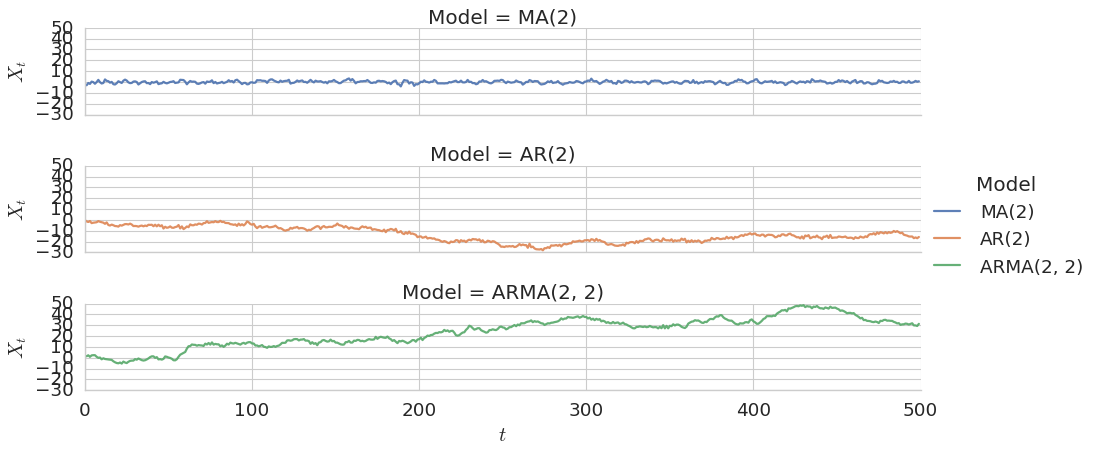

In [171]:
# large values of phi in the same sign -> magnitude grows large (non-stationary!)
ar_coefs = np.array([0.5, 0.5])
ma_coefs = np.array([0.5, 0.25])

samples = plot_arma_comparisons(ar_coefs, ma_coefs)

MA(2) stationarity & invertibility: True True
AR(2) stationarity & invertibility: True True
ARMA(2, 2) stationarity & invertibility: True True


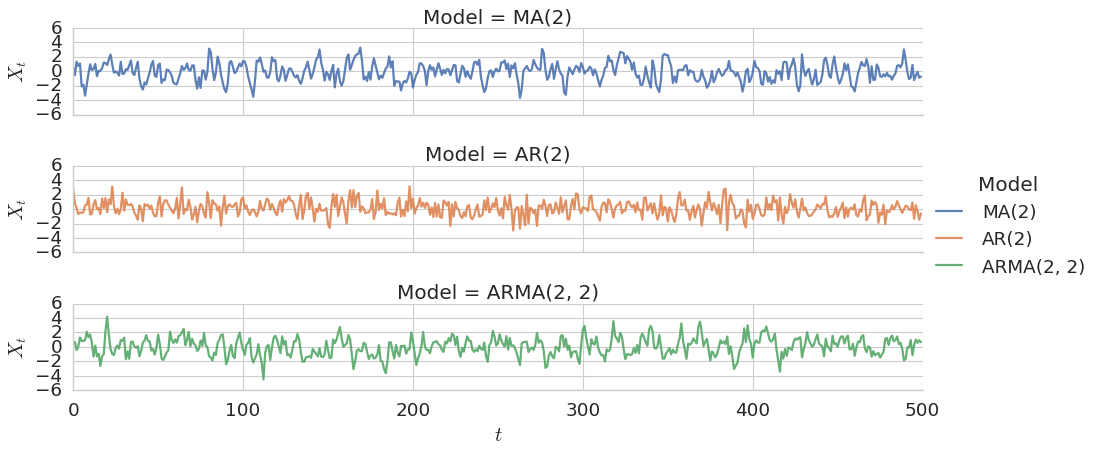

In [172]:
# smaller values of phi -> MA dominates
ar_coefs = np.array([0.01, -0.01])
ma_coefs = np.array([0.65, 0.35])

samples = plot_arma_comparisons(ar_coefs, ma_coefs)

## Diagnostics and Tests for AR Models

For AR/ARMA models, we need to check the validity of the model assumptions by examining the partial correlations.
We can plot the partial correlations using [`tsa.graphics.plot_pacf()`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html).
Furthermore, we can formally test the stationarity of an AR process via the (augmented) Dickey-Fuller test ([`tsa.adfuller()`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html)).

See upcoming lecture notes for further details.

For the **daily log-returns data**, the PACF plot shows that there are indeed significant partial correlations at lags 1-4, 6-9 and even 23, 26, and 27.

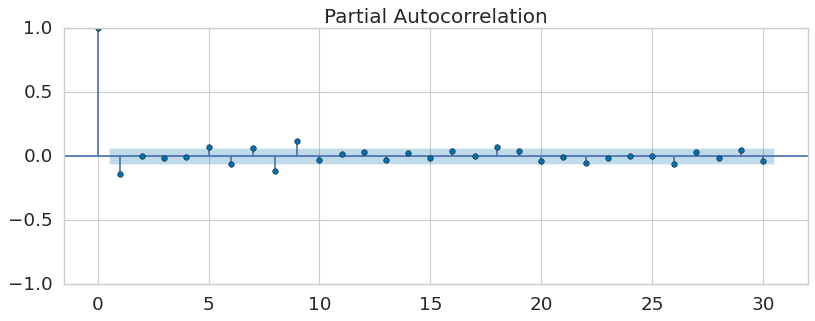

In [173]:
with plt.style.context(PLOT_STYLE):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    tsa.graphics.plot_pacf(log_returns, method="ywm", ax=ax)

The augmented Dickey-Fuller test gives us a "pass" that there is stationarity to be modeled in this time series.
This supports modeling this data using an AR/ARMA model.

In [174]:
# tstat, pvalue, nlags, nobs, critical_values, max_ic
tsa.adfuller(log_returns)

(-9.702151430928275,
 1.065135160542784e-16,
 8,
 928,
 {'1%': -3.4374162506455126,
  '5%': -2.8646595140022946,
  '10%': -2.568431020409111},
 -4425.031763104004)

On the other hand, the ADF test for the **passengers** dataset does not suggest any evidence of stationarity.

In [175]:
# tstat, pvalue, nlags, nobs, critical_values, max_ic
tsa.adfuller(passengers)

(0.8880265130074991,
 0.9929320626482829,
 13,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 888.9190559349265)

This is indeed because we did not remove the trend and seasonality that we detected in our earlier diagnosis.
We remove both the trend and seasonality in the log-domain and take the residuals.

The ADF test on this noise process indeed suggests that there is evidence of stationarity.

In [176]:
# remove season-trend via loess (STL: model version of seasonal_decompose)
stl = tsa.STL(log_passengers, period=12)
log_passengers_resid = stl.fit().resid

# tstat, pvalue, nlags, nobs, critical_values, max_ic
tsa.adfuller(log_passengers_resid)

(-5.746142306644695,
 6.11518063346839e-07,
 11,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 -603.6186463937813)

We can also check the partial correlations to check if an AR model is necessary.

We find significant partial autocorrelations at lags 1, 3, 10-12, and 21.

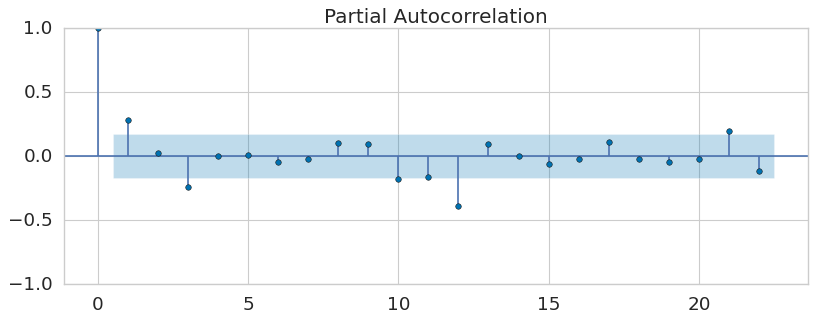

In [177]:
with plt.style.context(PLOT_STYLE):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    tsa.graphics.plot_pacf(log_passengers_resid, method="ywm", ax=ax)

## Fitting ARMA Models

To fit and validate the models, we now introduce a separate test set (unused in the previous section).

**Caution:** The 95% confidence intervals shown below, plotted by default in `statsmodels`, are only as accurate as the model assumptions are. They are often times too narrow in practice --- see [here](https://robjhyndman.com/hyndsight/narrow-pi/) and also [here](https://robjhyndman.com/hyndsight/intervals/).

In [178]:
def fit_and_plot_arima(
    data,
    order=(1, 0, 1),
    print_summary=True,
    plot=True,
    predict_start=None,
    predict_end=None,
    **plot_kwargs,
):
    """Fit an ARIMA(p, d, q) model on data (pd.Series) and plot its forecasts.

    Returns (results, model, ax).
    """
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # this really is how the name is determined
    p, d, q = order
    model_name = ""
    if p >= 1:
        model_name += "AR"
    if d >= 1:
        model_name += "I"
    if q >= 1:
        model_name += "MA"
    model_name += "({})".format(", ".join([str(o) for o in order if o >= 1]))

    # fit tsa.ARIMA & print summary
    fit_data = data if data.index.freq is not None else data.reset_index(drop=True)
    model = tsa.ARIMA(fit_data, order=order)
    results = model.fit()
    if print_summary:
        print(results.summary())

    if not plot:
        return results, model, None

    # plot_predict
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    tsa.graphics.plot_predict(
        results,
        start=predict_start,
        end=predict_end,
        ax=ax,
    )
    fit_data.plot(ax=ax, color="darkgray", alpha=0.5)
    ax.set(
        title=f"{model_name} fit on {data.name}",
        xlabel=r"$t$",
        ylabel=data.name,
        **plot_kwargs
    )

    return results, model, ax

### MA(1) on daily log-returns

                               SARIMAX Results                                
Dep. Variable:             LogReturns   No. Observations:                  937
Model:                 ARIMA(0, 0, 1)   Log Likelihood                2264.059
Date:                Mon, 17 Mar 2025   AIC                          -4522.119
Time:                        14:19:13   BIC                          -4507.590
Sample:                             0   HQIC                         -4516.579
                                - 937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.016      0.044    3.45e-05       0.002
ma.L1         -0.1439      0.022     -6.413      0.000      -0.188      -0.100
sigma2         0.0005   1.33e-05     35.018      0.0

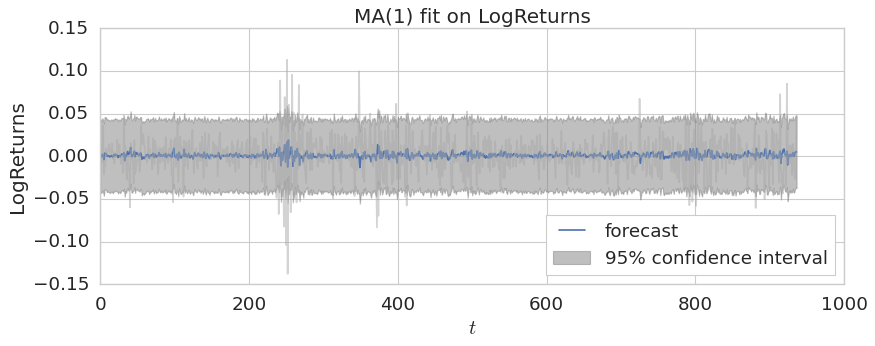

In [179]:
q = 1
results, model, ax = fit_and_plot_arima(log_returns, order=(0, 0, q))

### AR(1) on daily log-returns

                               SARIMAX Results                                
Dep. Variable:             LogReturns   No. Observations:                  937
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2264.233
Date:                Mon, 17 Mar 2025   AIC                          -4522.467
Time:                        14:19:13   BIC                          -4507.939
Sample:                             0   HQIC                         -4516.928
                                - 937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.997      0.046    2.31e-05       0.002
ar.L1         -0.1441      0.021     -6.856      0.000      -0.185      -0.103
sigma2         0.0005   1.33e-05     34.980      0.0

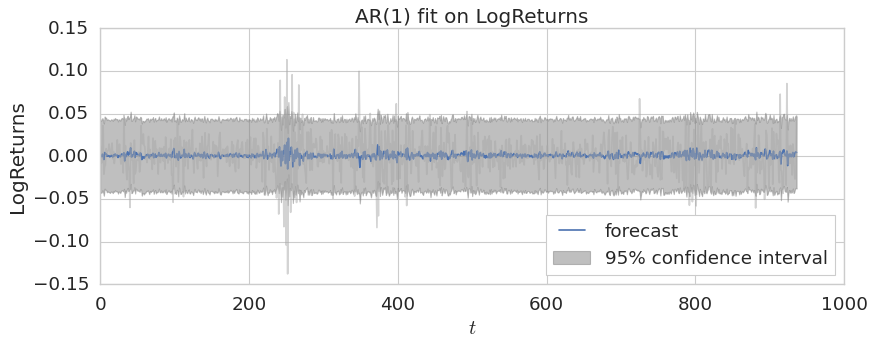

In [180]:
p = 1
results, model, ax = fit_and_plot_arima(log_returns, order=(p, 0, 0))

### ARMA(1, 1) on daily log-returns

                               SARIMAX Results                                
Dep. Variable:             LogReturns   No. Observations:                  937
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2264.235
Date:                Mon, 17 Mar 2025   AIC                          -4520.469
Time:                        14:19:14   BIC                          -4501.098
Sample:                             0   HQIC                         -4513.084
                                - 937                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.930      0.054   -1.94e-05       0.003
ar.L1         -0.1557      0.142     -1.096      0.273      -0.434       0.123
ma.L1          0.0118      0.148      0.079      0.9

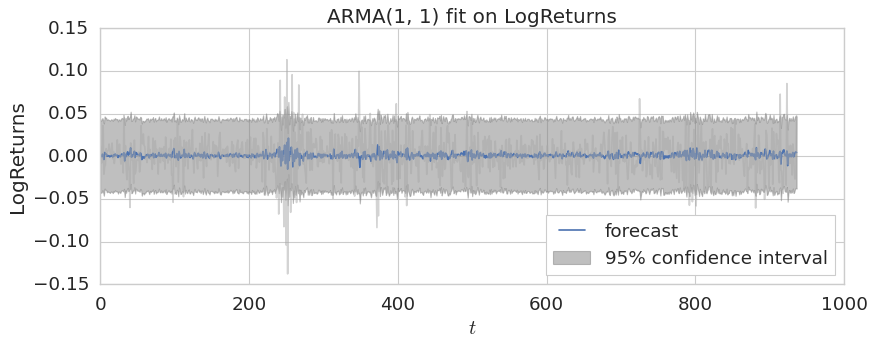

In [181]:
p, q = 1, 1
results, model, ax = fit_and_plot_arima(log_returns, order=(p, 0, q))

### *ARIMA(1, 1, 1) on prices

Although we did not cover this yet, the second argument to `ARIMA` represents a _differencing_ operator, which can remove the trend component. This makes it suitable for applying it directly to the price process.

Here, the fit isn't quite ideal (very high BIC, for example), so we focus on log-returns. Also note that the confidence intervals are likely very misleading, as the model fit itself is not good.

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  938
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2187.336
Date:                Mon, 17 Mar 2025   AIC                           4380.673
Time:                        14:19:15   BIC                           4395.201
Sample:                             0   HQIC                          4386.212
                                - 938                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3387      0.301      1.125      0.260      -0.251       0.929
ma.L1         -0.4086      0.295     -1.387      0.166      -0.986       0.169
sigma2         6.2392      0.198     31.589      0.0

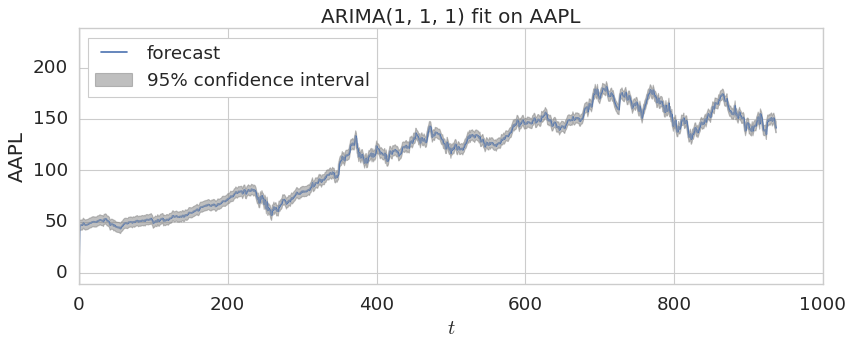

In [182]:
p, d, q = 1, 1, 1

m, sd = prices.mean(), prices.std()  # for plotting
results, model, ax = fit_and_plot_arima(
    prices, order=(p, d, q), ylim=(m - 3 * sd, m + 3 * sd))

### MA(1), AR(1), and ARMA(1, 1) on (the noise process of) log-passengers

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  132
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 332.629
Date:                Mon, 17 Mar 2025   AIC                           -657.259
Time:                        14:19:15   BIC                           -645.728
Sample:                    01-01-1949   HQIC                          -652.573
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.143      0.887      -0.005       0.004
ar.L1          0.2905      0.262      1.109      0.267      -0.223       0.804
ma.L1         -0.0159      0.270     -0.059      0.9

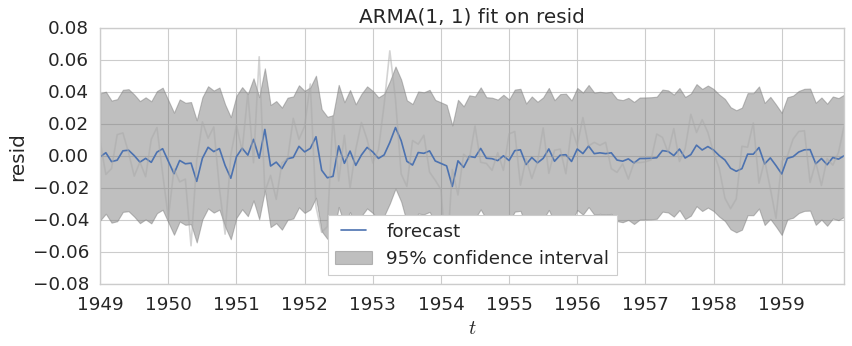

In [183]:
p, q = 1, 1
results, model, ax = fit_and_plot_arima(log_passengers_resid, order=(p, 0, q))

This is a **much better** fit than, say, fitting an ARMA(1, 1) directly on log-passengers, as demonstrated by any of the evaluation metrics below (log-likelihood, AIC, or BIC).

While the CIs look more reasonable in this case, one should also be careful with interpretin, e.g., the coefficients.
It appears that the AR and MA coefficients are insignificant under the model assumption; yet, as we will see later, the AR component ends up being useful when it comes to prediction.

                               SARIMAX Results                                
Dep. Variable:          LogPassengers   No. Observations:                  132
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 111.270
Date:                Mon, 17 Mar 2025   AIC                           -214.539
Time:                        14:19:16   BIC                           -203.008
Sample:                    01-01-1949   HQIC                          -209.853
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4581      0.217     25.209      0.000       5.034       5.883
ar.L1          0.9587      0.026     36.479      0.000       0.907       1.010
ma.L1          0.2860      0.114      2.513      0.0

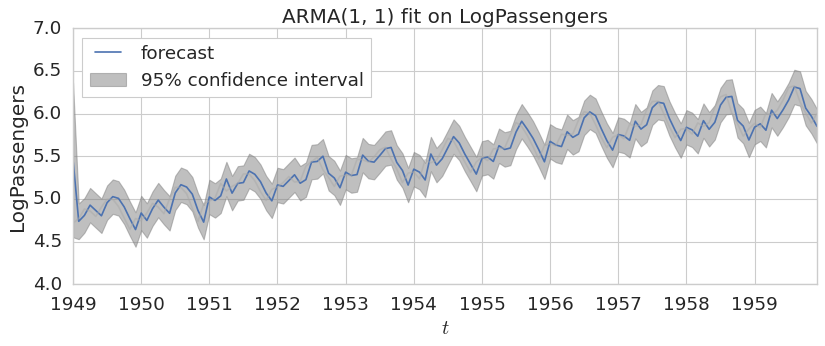

In [184]:
p, d, q = 1, 0, 1
results, model, ax = fit_and_plot_arima(log_passengers, order=(p, d, q))

In [185]:
100*np.exp(results.get_forecast(10).summary_frame().cumsum())

LogPassengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1960-01-01,4.136349e+04,110.842328,3.380615e+04,5.061026e+04
1960-02-01,1.671352e+07,130.642721,9.897944e+06,2.822219e+07
1960-03-01,6.603467e+09,160.397513,2.615725e+09,1.667063e+10
1960-04-01,2.553478e+12,203.209436,6.361700e+11,1.024922e+13
1960-05-01,9.672395e+14,264.113205,1.441586e+14,6.489742e+15
1960-06-01,3.592094e+17,350.719079,3.070768e+16,4.201927e+18
1960-07-01,1.308965e+20,474.366907,6.191103e+18,2.767501e+21
1960-08-01,4.683975e+22,651.932195,1.187975e+21,1.846809e+24
1960-09-01,1.647152e+25,908.592109,2.179541e+23,1.244808e+27
1960-10-01,5.696365e+27,1282.048741,3.838352e+25,8.453778e+29


## Forecasting with ARMA Models

ARMA models can be used to make forecasts on future values of the noise process.

Here, we illustrate the basic pipeline for making such forecasts.
`statsmodels` includes the `STLForecast` module, which allows to combine an STL decomposition and an ARIMA noise model for making forecasts.

Also note that, for prediction purposes, the values of $p, d, q$ can be chosen on a held-out validation set (as in Part II), according to either the MSE or some model selection criterion (AIC/BIC/log-likelihood from above). This is left as an exercise.

In [186]:
def plot_arma_forecasts(train_data, test_data,
                        ps=(0, 1), ds=(0, ), qs=(0, 1),
                        plot=True, logret_to_price=False, prices=None,
                        ci=False, alpha=0.05,
                        last_n_days=0):
    """Make forecasts using a set of ARIMA models and plot them."""

    forecasts = {}
    for p, d, q in itertools.product(ps, ds, qs):
        if p == 0 and q == 0:
            continue
        model_name = ""
        if p >= 1:
            model_name += "AR"
        if d >= 1:
            model_name += "I"
        if q >= 1:
            model_name += "MA"
        order = (p, d, q)
        model_name += "({})".format(", ".join([str(o) for o in order if o >= 1]))

        n_forecasts = len(test_data)
        print(f"Fitting {model_name}...")

        results, model, _ = fit_and_plot_arima(train_data, order=order,
                                               print_summary=False, plot=False)
        # mean only
        forecasts[model_name] = results.get_forecast(n_forecasts).summary_frame()
        forecasts[model_name].index = test_data.index

    forecasts["Mean"] = pd.Series(
        data=np.repeat(np.mean(train_data), len(test_data)),
        index=test_data.index,
    )

    if plot:

        def _plot_forecasts(forecasts):
            with plt.style.context(PLOT_STYLE):
                fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
                palette = sns.color_palette()
                for i, (model_name, fcs) in enumerate(forecasts.items()):
                    fcs = fcs[-last_n_days:]
                    if isinstance(fcs, pd.DataFrame):
                        # Mean
                        fcs["mean"].plot(
                            ax=ax, alpha=0.7, color=palette[i],
                            linewidth=3, linestyle="dashed", label=model_name)
                        # CI
                        if ci:
                            ax.fill_between(
                                fcs.index,
                                fcs["mean_ci_lower"],
                                fcs["mean_ci_upper"],
                                alpha=0.1,
                                color=palette[i],
                            )
                    else:
                        fcs.plot(
                            ax=ax, alpha=0.7, color=palette[i],
                            linewidth=3, linestyle="dashed", label=model_name)
                ax.axvline(train_data.index[-1],
                           color="gray", alpha=0.7, linewidth=3, linestyle="dashed")
                ax.legend(ncol=2)
                return ax


        ax = _plot_forecasts(forecasts)
        pd.concat([train_data, test_data], axis=0)[-last_n_days:].plot(
            ax=ax, color="darkgray", alpha=0.5, linewidth=3,
        )
        days_str = (
            f" (last {last_n_days} days shown)" if last_n_days > 0 else ""
        )
        ax.set(
            title=f"ARMA forecasts: {SYMBOL} prices" + days_str,
            ylabel=train_data.name,
        )


        if logret_to_price:
            assert prices is not None and isinstance(prices, pd.Series), \
                f"must specify the actual prices of the train+test data"
            price_at_T = prices.loc[train_data.index[-1]]
            price_forecasts = {
                model_name: price_at_T * np.exp(fcs.cumsum())
                for model_name, fcs in forecasts.items()
            }
            ax = _plot_forecasts(price_forecasts)
            prices[-last_n_days:].plot(
                ax=ax, color="darkgray", alpha=0.5,
                linewidth=3, label="Actual Price",
            )
            m, sd = prices.mean(), prices.std()
            ax.set(
                title=f"ARMA forecasts: {train_data.name}" + days_str,
                ylabel="Price",
            )
    return forecasts

### Daily Log-Returns

Fitting MA(1)...
Fitting AR(1)...
Fitting ARMA(1, 1)...
Fitting AR(9)...
Fitting ARMA(9, 1)...


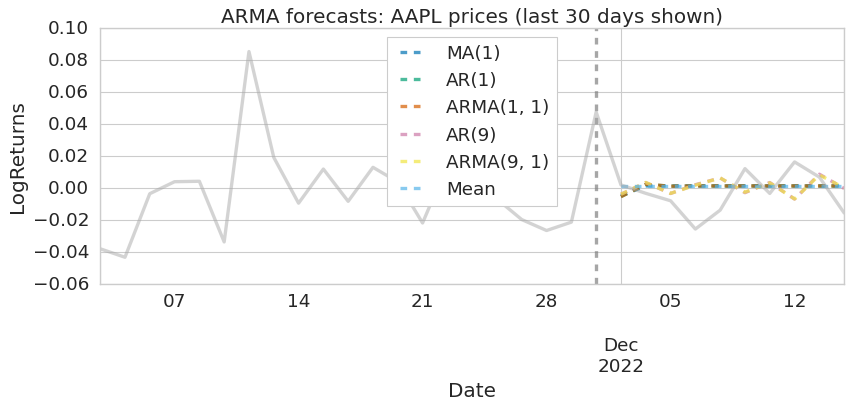

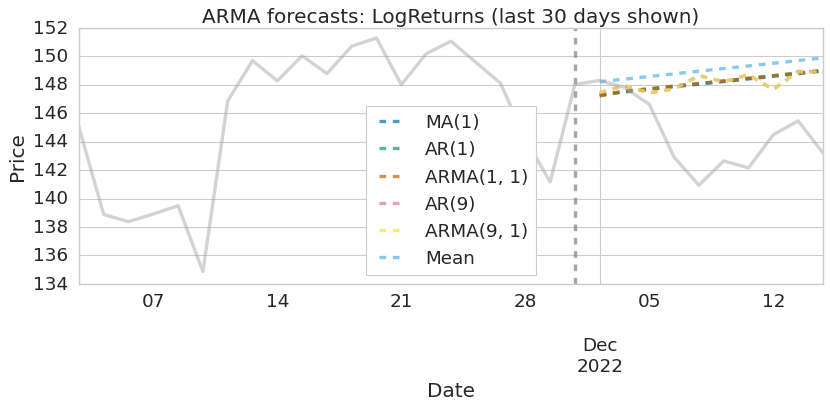

In [152]:
log_returns_forecasts = plot_arma_forecasts(
    log_returns,
    log_returns_test,
    ps=(0, 1, 9),
    qs=(0, 1),
    logret_to_price=True,
    prices=pd.concat([prices, prices_test], axis=0),
    plot=True,
    last_n_days=30,
)

None of the fits are quite ideal. Having said that, the ARMA(9, 1) model stands out by being able to model the decreasing pattern within the first few days. Unsurprisingly, none of the models can predict sudden drops in prices, such as the one occurring after ~4 days into December.

### Passengers

Fitting MA(1)...
Fitting AR(1)...
Fitting ARMA(1, 1)...
Fitting AR(12)...
Fitting ARMA(12, 1)...


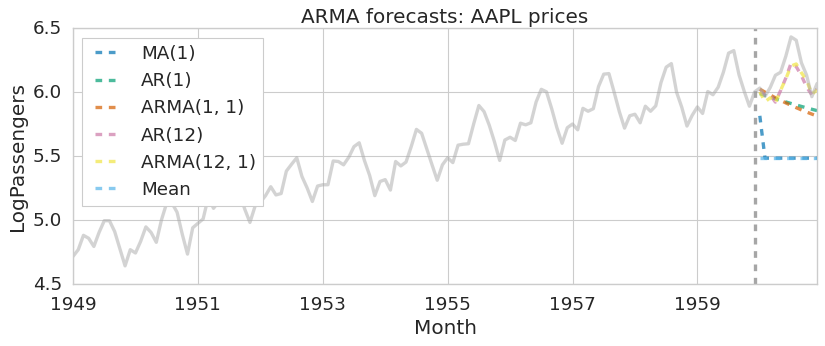

In [153]:
log_passengers_forecasts = plot_arma_forecasts(
    log_passengers,
    log_passengers_test,
    ps=(0, 1, 12),
    qs=(0, 1),
    logret_to_price=False,
    plot=True,
)

Because we did not remove the trend or the seasonality of the data here, non of the forecasts adequately capture the seasonal spikes or the increasing trend overall.

By including the past 12 terms in the AR model ($p=12$), we can somewhat capture the seasonality in our fit, but as we see below the fit will be much better by simply removin the trend and the seasonality first (when appropriate).

### Passengers after removing trend and seasonality (`STLForecast`)

Finally, in order to build a forecaster that combines season-trend decomposition via loess (STL) and a noise model (e.g., ARIMA), we can use [`tsa.STLForecast(data, tsa.ARIMA, **arima_kwargs)`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.forecasting.stl.STLForecast.html).

We illustrate this using the passengers data, for which we have a reasonable STL decomposition.

In [154]:
models = {
    "AR(1)": (1, 0, 0),
    "MA(1)": (0, 0, 1),
    "ARMA(1, 1)": (1, 0, 1),
}

predictions = {}
n_forecasts = len(log_passengers_test)
for model_name, order in models.items():
    print(f"Fitting {model_name}...")
    stlf = tsa.STLForecast(log_passengers, tsa.ARIMA,
                           model_kwargs=dict(order=order, trend="t"))
    stlf_res = stlf.fit()
    predictions[model_name] = stlf_res.forecast(n_forecasts)
    predictions[model_name].index = log_passengers_test.index

predictions["Mean"] = pd.Series(
    data=np.repeat(np.mean(log_passengers), len(log_passengers_test)),
    index=log_passengers_test.index,
)

Fitting AR(1)...
Fitting MA(1)...
Fitting ARMA(1, 1)...


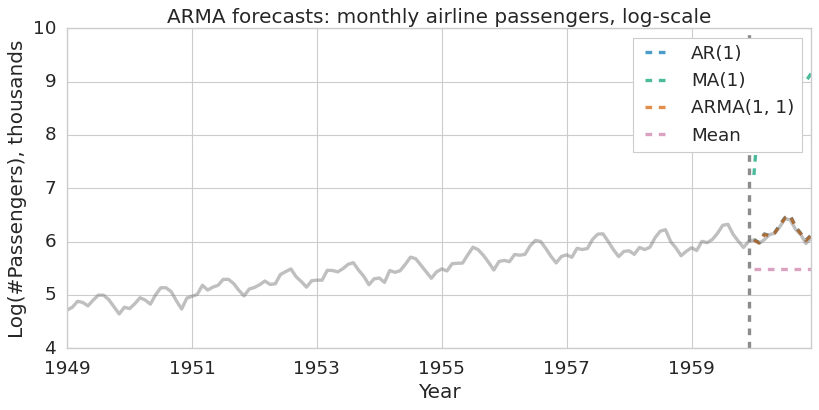

In [155]:
with plt.style.context(PLOT_STYLE):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    pd.concat([log_passengers, log_passengers_test], axis=0).plot(
        ax=ax, color="gray", linewidth=3, alpha=0.5)
    for model_name, preds in predictions.items():
        preds.plot(ax=ax, label=model_name,
                   linewidth=3, linestyle="dashed", alpha=0.7)
    ax.axvline(PASSENGERS_END, color="gray",
               linewidth=3, alpha=0.9, linestyle="dashed")
    ax.set(
        title=f"ARMA forecasts: monthly airline passengers, log-scale",
        xlabel="Year",
        ylabel="Log(#Passengers), thousands",
        #xlim=(log_passengers.index[-60], log_passengers_test.index[-1]),
    )
    ax.legend()
None

All AR-based models, even with just $p=1$, make very reasonable forecasts when combined with a `STL` model.

In contrast, the MA models and the simple mean models do not perform reasonably.

---

## Going Forward

- **Formal introduction to AR/MA/ARMA/ARIMA**: We will soon learn in class about ARIMA, which further incorporates the differencing operator to ARMA.
- **AutoARIMA using `pmdarima`**: For accurate predictions, one could choose to optimize the hyperparameters for the ARIMA model by running hyperparameter search on $(p,d,q)$ using an information criterion. This can be done using [`pmdarima.arima.auto_arima()`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).
- **ARCH/GARCH**: Unfortunately, the ARIMA family of models cannot model a crucial aspect of financial data that is often referred to as _volatility clustering_. We will learn in a later class how to model a noise process whose variance can cluster among certain time periods.